In [1]:
from __future__ import division

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
batch_size = 10
epochs = 10
noise = 0.2
ratio_of_training = 0.5
dataset = 'circle'
features = ['x','y', 'x**2', 'y**2', 'x*y', 'sinx', 'siny']
layers = [6, 8, 6, 6]
lr = 0.03
activation = 'tanh'
regularization = 'l2'
regularization_rate = 0.003

In [5]:
assert activation in ['tanh', 'sigmoid', 'relu']
assert dataset in ['circle', 'xor', 'spiral']
assert regularization in [None, 'l1', 'l2']

In [6]:
if regularization == 'l1':
    regularizer = keras.regularizers.l1(regularization_rate)
elif regularization == 'l2':
    regularizer = keras.regularizers.l2(regularization_rate)
else :
    regularizer = None

In [7]:
def classify_circle_data(num_samples=1, noise=0):
    radius = 5
    def get_circle_label(x, y):
        return 1 if (np.sqrt(x**2 + y**2) < (radius * 0.5)) else 0
    points = []
    labels = []
    
    # Generate positive points inside the circle.
    for i in range(num_samples // 2):
        r = np.random.uniform(0, 0.5 * radius)
        angle = np.random.uniform(0, 2 * np.math.pi)
        x = r * np.math.sin(angle)
        y = r * np.math.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_circle_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
        
    # Generate negative points inside the circle.
    for i in range(num_samples // 2):
        r = np.random.uniform(radius * 0.7, radius)
        angle = np.random.uniform(0, 2 * np.math.pi)
        x = r * np.math.sin(angle)
        y = r * np.math.cos(angle)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_circle_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
    
    return np.array(points), np.array(labels)

In [8]:
def classify_xor_data(num_samples=1, noise=0):
    radius = 5
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else 0
    points = []
    labels = []
    padding = 0.3
    for i in range(num_samples):
        x = np.random.uniform(-5, 5)
        x += (padding if x >0 else -padding)
        y = np.random.uniform(-5, 5)
        y += (padding if y >0 else -padding)
        noise_x = np.random.uniform(-radius, radius) * noise;
        noise_y = np.random.uniform(-radius, radius) * noise;
        label = get_xor_label(x + noise_x, y + noise_y)
        points.append([x,y])
        labels.append(label)
    return np.array(points), np.array(labels)

In [9]:
def classify_spiral_data(num_samples=1, noise=0):
    points = []
    labels = []
    n = num_samples // 2
    def gen_spiral(deltaT, label):
        for i in range(n):
            r = i / n * 5
            t = 1.75 * i / n * 2 * np.math.pi + deltaT
            x = r * np.math.sin(t) + np.random.uniform(-1, 1) * noise
            y = r * np.math.cos(t) + np.random.uniform(-1, 1) * noise
            points.append([x,y])
            labels.append(label)
    gen_spiral(0,1)
    gen_spiral(np.math.pi, -1)
    return np.array(points), np.array(labels)

In [10]:
data_gen = {'circle': classify_circle_data,
            'xor': classify_xor_data,
            'spiral': classify_spiral_data}

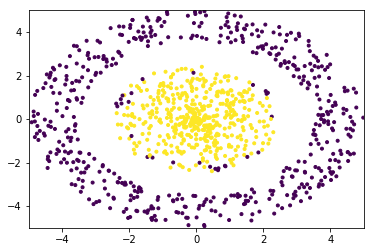

In [11]:
X1, Y1 = data_gen[dataset](num_samples=1000, noise=0.1)
plt.scatter(X1[:, 0], X1[:, 1], marker='.', c=Y1)
plt.axis([-5, 5, -5, 5])
plt.show()

In [12]:
train_xy, train_label = data_gen[dataset](num_samples=int(1000 * ratio_of_training), noise=noise)
test_xy, test_label = data_gen[dataset](num_samples=int(1000 * (1 - ratio_of_training)), noise=noise)
print ("train_xy.shape: ", train_xy.shape)
print ("train_label.shape: ", train_label.shape)

train_xy.shape:  (500, 2)
train_label.shape:  (500,)


In [13]:
train_x = train_xy[:, 0]
train_y = train_xy[:, 1]
print ("train_x.shape: ", train_x.shape)
print ("train_y.shape: ", train_y.shape)
test_x = test_xy[:, 0]
test_y = test_xy[:, 1]

train_list = []
test_list = []
for feature in features:
    if feature == 'x':
        train_list.append(train_x)
        test_list.append(test_x)
    if feature == 'y':
        train_list.append(train_y)
        test_list.append(test_y)
    if feature == 'x**2':
        train_list.append(np.square(train_x))
        test_list.append(np.square(test_x))
    if feature == 'y**2':
        train_list.append(np.square(train_y))
        test_list.append(np.square(test_y))
    if feature == 'x*y':
        train_list.append(train_x * train_y)
        test_list.append(test_x * test_y)
    if feature == 'sinx':
        train_list.append(np.sin(train_x))
        test_list.append(np.sin(test_x))
    if feature == 'siny':
        train_list.append(np.sin(train_y))
        test_list.append(np.sin(test_y))

train_data = np.stack(train_list, axis=1)
test_data = np.stack(test_list, axis=1)
# king
print ("train_data.shape: ", train_data.shape)

train_x.shape:  (500,)
train_y.shape:  (500,)
train_data.shape:  (500, 7)


In [14]:
# def get_model(layers=[], activation='relu', input_shape=(2,)):
#     model = keras.Sequential()
#     if layers:
#         model.add(keras.layers.Dense(
#             layers[0], activation=activation, kernel_regularizer=regularizer, input_shape=input_shape))
#         for units in layers[1:]:
#             model.add(keras.layers.Dense(
#                 units=units, activation=activation, kernel_regularizer=regularizer))
#     model.add(keras.layers.Dense(2, activation='softmax'))
#     return model
# model = get_model(layers=layers, activation='relu',input_shape = (len(features),))

In [15]:
inputs = keras.Input(shape=(len(features),))
x = inputs
for units in layers:
    x = keras.layers.Dense(units, activation=tf.nn.tanh, kernel_regularizer=regularizer)(x)
outputs = keras.layers.Dense(2, activation=tf.nn.softmax, kernel_regularizer=regularizer)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
# class Model(tf.keras.Model):
#   def __init__(self, layers, activation):
#     super(Model, self).__init__()
#     self.fcs = [keras.layers.Dense(units, activation=activation) for units in layers]
#     self.classifier = keras.layers.Dense(2, activation=tf.nn.softmax)
    
#   def call(self, x):
#     for fc in self.fcs:
#         x = fc(x)
#     return self.classifier(x)

# model = Model(layers, activation)

In [17]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

<img src='model.png'>

In [18]:
model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr), 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
model.build(tf.TensorShape([batch_size, len(features)]))

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 56        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 14        
Total params: 214
Trainable params: 214
Non-trainable params: 0
_________________________________________________________________


In [21]:
print ("train_data.shape: ", train_data.shape)
print ("train_label.shape: ", train_label.shape)

train_data.shape:  (500, 7)
train_label.shape:  (500,)


In [22]:
model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size)

Epoch 1/10
500/500 [==============================] - 0s 623us/step - loss: 0.5763 - acc: 0.8000
Epoch 2/10
500/500 [==============================] - 0s 144us/step - loss: 0.3787 - acc: 0.9120
Epoch 3/10
500/500 [==============================] - 0s 158us/step - loss: 0.2939 - acc: 0.9320
Epoch 4/10
500/500 [==============================] - 0s 159us/step - loss: 0.2590 - acc: 0.9380
Epoch 5/10
500/500 [==============================] - 0s 151us/step - loss: 0.2582 - acc: 0.9280
Epoch 6/10
500/500 [==============================] - 0s 163us/step - loss: 0.2474 - acc: 0.9300
Epoch 7/10
500/500 [==============================] - 0s 173us/step - loss: 0.2455 - acc: 0.9340
Epoch 8/10
500/500 [==============================] - 0s 177us/step - loss: 0.2510 - acc: 0.9360
Epoch 9/10
500/500 [==============================] - 0s 176us/step - loss: 0.2365 - acc: 0.9420
Epoch 10/10
500/500 [==============================] - 0s 195us/step - loss: 0.2362 - acc: 0.9340


In [ ]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [ ]:
model.save_weights(checkpoint_prefix)

In [ ]:
# model = Model(layers, activation)
# model = get_model(layers=layers, activation='relu',input_shape = (len(features),))
model = keras.Model(inputs=inputs, outputs=outputs)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=lr), 
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

# model.build(tf.TensorShape([1, len(features)]))

In [ ]:
model.evaluate(test_data,test_label)

In [ ]:
X1, Y1 = test_data, test_label
plt.scatter(X1[:, 0], X1[:, 1], marker='.', c=Y1)
plt.axis([-5, 5, -5, 5])
plt.show()

In [ ]:
X2, Y2 = test_data, np.argmax(model.predict(test_data),axis=1)
plt.scatter(X2[:, 0], X2[:, 1], marker='.', c=Y2)
plt.axis([-5, 5, -5, 5])
plt.show()